In [446]:
# import numpy as np
import autograd.numpy as np
from autograd import grad
import matplotlib 
import matplotlib as mpl

from astropy.table import Table
from skimage.transform import resize,downscale_local_mean

import manhattan.periodograms as cs 
from exotk.utils.misc import fold
from pytransit import MandelAgol
from spgl1 import spg_bp, spg_lasso
import aflare # jim davenport's flare model

%pylab inline --no-import-all
matplotlib.rcParams['image.origin'] = 'lower'
matplotlib.rcParams['figure.figsize']=(10.0,10.0)    #(6.0,4.0)
matplotlib.rcParams['font.size']=16              #10 
matplotlib.rcParams['savefig.dpi']= 300             #72 
matplotlib.rcParams['axes.facecolor']='white'
matplotlib.rcParams['savefig.facecolor']='white'

colours = mpl.rcParams['axes.color_cycle'] 


Populating the interactive namespace from numpy and matplotlib


## Basis Pursuit for Flare Searches

How can we fit a sparse basis of flares?

In [438]:
epochs = np.random.choice(time,size=5,replace=False)
print epochs

[97.95095902 66.45032901 88.55077102 76.25052501 65.05030101]


In [364]:
time = np.linspace(0,100,50000)
y = np.ones_like(time)

# insert flares
epochs = np.random.choice(time,size=5,replace=False)
duration = 0.05
amps = 0.05*np.random.rand(len(epochs))

for j, epoch in enumerate(epochs):
    y += aflare.aflare1(time,epoch,duration,amps[j])

time = downscale_local_mean(time,(50,))
y = downscale_local_mean(y,(50,))

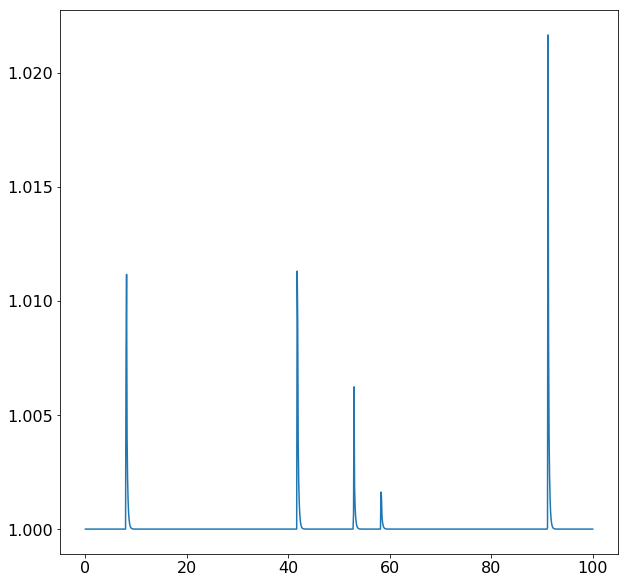

In [365]:
plt.plot(time,y)
# plt.plot(fold(time,p),f,'.')

In [392]:
%%time
# do this in terms of epochs
tt = np.linspace(0,100,20000)

X = np.ones([len(time),len(tt)+1])

flare_temp = aflare.aflare1(tt, tt[0], duration, 1) 
flare_temp /= np.trapz(flare_temp)

for j in range(tt.shape[0]):
    X[:,j] = downscale_local_mean(aflare.aflare1(tt,tt[j],duration,1),(20,))
    
X[:,-1] = 1.

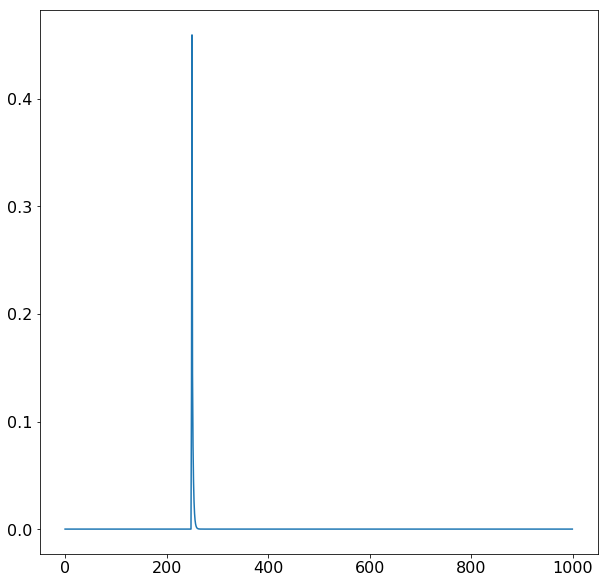

In [436]:
plt.plot(X[:,5000])

### For basis pursuit: 
https://github.com/drrelyea/SPGL1_python_port 

### minimize ||x||_1 subject to Xx = y




In [394]:
%%time
x,resid,grad,info = spg_bp(X, y)

CPU times: user 22.6 s, sys: 268 ms, total: 22.9 s
Wall time: 7.83 s


In [395]:
sim = np.dot(X,x)

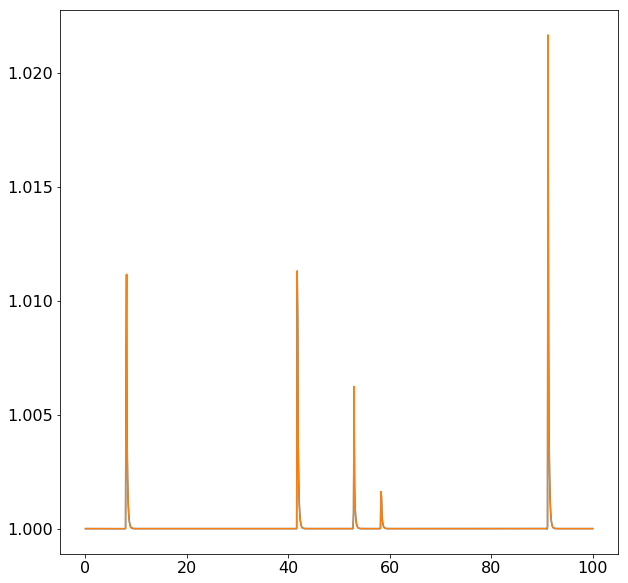

In [397]:
plt.plot(time,sim)
plt.plot(time,y)

Text(0,0.5,u'Amplitude')

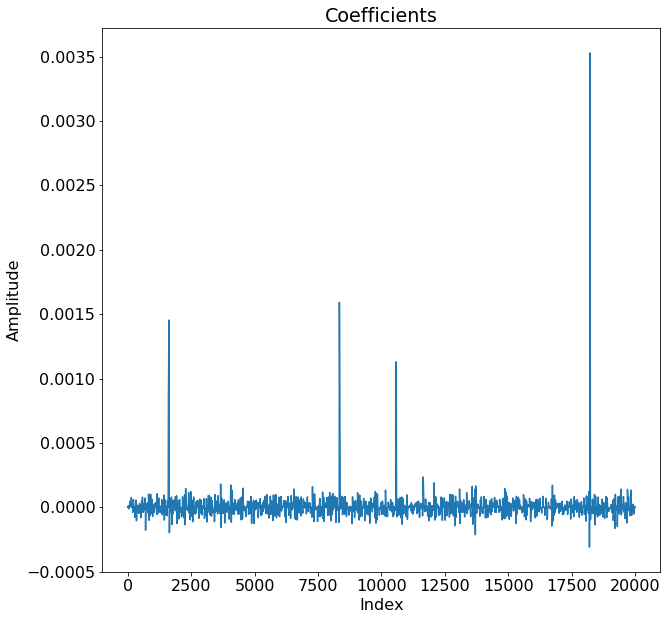

In [435]:
plt.plot(x[:-1])
plt.title("Coefficients")
plt.xlabel("Index")
plt.ylabel("Amplitude")

## Now try with noise


In [414]:
%%time
noise = 0.00025*np.random.randn(len(y))
x,resid,grad,info = spg_bp(X, y+noise)

CPU times: user 22 s, sys: 292 ms, total: 22.3 s
Wall time: 7.75 s


In [415]:
sim = np.dot(X,x)

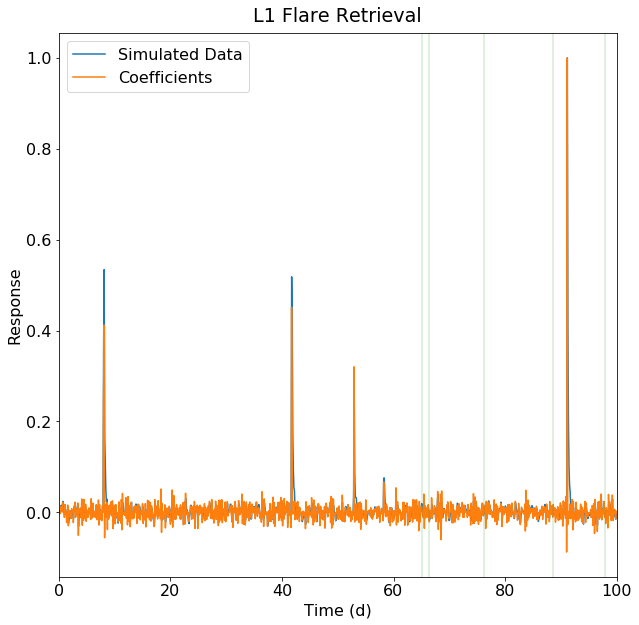

In [445]:
# plt.plot(time,sim)
plt.plot(time,(y+noise-1)/(y+noise-1.).max(),label="Simulated Data")
plt.plot(tt,x[:-1]/x[:-1].max(),label="Coefficients")
plt.xlim(0,100)
for epoch in epochs:
    plt.axvline(epoch,color=colours[2],alpha=0.2)
    
plt.xlabel("Time (d)")
plt.ylabel("Response")
plt.legend()
plt.title("L1 Flare Retrieval",y=1.01)
plt.savefig('flares.jpg')

In [422]:
tt.shape

(20000,)